### 1️⃣ Chargement du dataset brut

Le fichier `training.1600000.processed.noemoticon.csv` contient **1,6 million de tweets annotés** pour l’analyse de sentiment.
Les tweets sont étiquetés avec `target = 0` (négatif) ou `4` (positif). Il n'y a pas d’exemple "neutre".

Nous chargeons ici le jeu de données en spécifiant manuellement les noms de colonnes :
- `target` : étiquette du sentiment
- `text` : contenu du tweet (champ d'intérêt)


In [1]:
import pandas as pd

# Définir le chemin vers le dataset
dataset_path = "../data/training.1600000.processed.noemoticon.csv"

# Charger les données (pas d’en-têtes → on les spécifie)
columns = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv(dataset_path, encoding='latin-1', names=columns)

# Aperçu des premières lignes
df.head()


,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Analyse de la distribution des classes

Répartition des classes :
 label
0    800000
1    800000
Name: count, dtype: int64


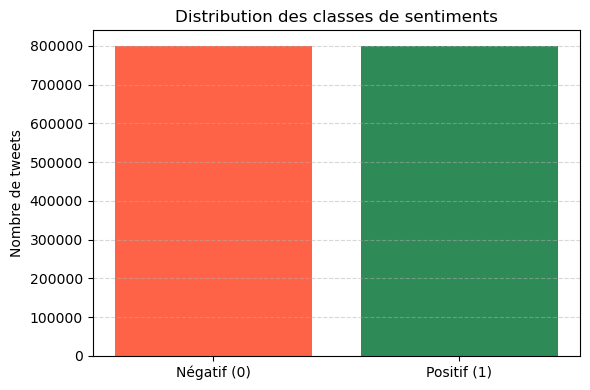

In [2]:
import matplotlib.pyplot as plt

# Convertir les labels en binaire : 0 = négatif, 1 = positif
df["label"] = df["target"].apply(lambda x: 1 if x == 4 else 0)

# Comptage brut
class_counts = df["label"].value_counts().sort_index()
print("Répartition des classes :\n", class_counts)

# Visualisation
plt.figure(figsize=(6, 4))
plt.bar(["Négatif (0)", "Positif (1)"], class_counts, color=["tomato", "seagreen"])
plt.title("Distribution des classes de sentiments")
plt.ylabel("Nombre de tweets")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


### Nettoyage des données inutiles

In [3]:
# Valeurs uniques de la colonne 'flag'
unique_flags = df["flag"].value_counts()

print("Valeurs uniques de la colonne 'flag' :")
print(unique_flags)


Valeurs uniques de la colonne 'flag' :
flag
NO_QUERY    1600000
Name: count, dtype: int64


In [4]:
# Suppression des colonnes non utilisées pour la tâche
df.drop(columns=["date", "flag", "user", "target"], inplace=True)

# Vérification des colonnes restantes
df.head()


,ids,text,label
0,1467810369,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,1467810672,is upset that he can't update his Facebook by ...,0
2,1467810917,@Kenichan I dived many times for the ball. Man...,0
3,1467811184,my whole body feels itchy and like its on fire,0
4,1467811193,"@nationwideclass no, it's not behaving at all....",0


In [5]:
# Nombre de NaN
nb_nan = df["text"].isna().sum()

# Nombre de chaînes vides (ou espaces uniquement)
nb_empty = (df["text"].astype(str).str.strip() == "").sum()

# Total des cas problématiques
total_problematic = nb_nan + nb_empty

print(f"📦 Nombre de NaN : {nb_nan}")
print(f"🈳 Nombre de textes vides : {nb_empty}")

📦 Nombre de NaN : 0
🈳 Nombre de textes vides : 0


### Anonymisation des données

Les pseudonymes ne devraient pas apporter de valeur pour classifier les tweets dans notre cas.

In [6]:
import re

def anonymize_mentions(text: str) -> str:
    """
    Supprime les mentions @username pour anonymisation RGPD.
    """
    return re.sub(r'@[\w_]+', '', text).strip()

# Application RGPD
df["anonymized_text"] = df["text"].apply(anonymize_mentions)

# Exemple
df[["text", "anonymized_text"]].sample(42).values


array([['@rwdave noise-boy antics?  Do I want to ask or know more? ',
        'noise-boy antics?  Do I want to ask or know more?'],
       ['@Silveysurfer they also removed the family photos &amp; story from the menu.  I loved that part! Still WAY better than Knoxville Italian.',
        'they also removed the family photos &amp; story from the menu.  I loved that part! Still WAY better than Knoxville Italian.'],
       ["my laptop died. I'm pissed. I'm sorry but I won't be able to update fanfiction until I get it fixed. Hopefully it doesn't take too long. ",
        "my laptop died. I'm pissed. I'm sorry but I won't be able to update fanfiction until I get it fixed. Hopefully it doesn't take too long."],
       ['just woke up from my nap and the feeling of making a vid is coming to me man if i only had some &quot;AA&quot; batteries ',
        'just woke up from my nap and the feeling of making a vid is coming to me man if i only had some &quot;AA&quot; batteries'],
       ['bummer, th

In [7]:
# Nombre de NaN
nb_nan = df["anonymized_text"].isna().sum()

# Nombre de chaînes vides (ou espaces uniquement)
nb_empty = (df["anonymized_text"].astype(str).str.strip() == "").sum()

# Total des cas problématiques
total_problematic = nb_nan + nb_empty

print(f"📦 Nombre de NaN : {nb_nan}")
print(f"🈳 Nombre de textes vides : {nb_empty}")
print(f"❗ Total à traiter : {total_problematic} / {len(df)} ({round(total_problematic / len(df) * 100, 4)}%)")


📦 Nombre de NaN : 0
🈳 Nombre de textes vides : 2717
❗ Total à traiter : 2717 / 1600000 (0.1698%)


> Certains tweet n'étaient constitué que d'une citation d'un pseudonyme et se retrouvent donc vide, il faut les traiter

In [8]:
# Supprime les lignes où 'text' est NaN ou vide après strip
df = df[~df["anonymized_text"].isna()]
df = df[df["anonymized_text"].str.strip() != ""]


> On vérifie de nouveau la répartition des classes après suppression d'individus

In [9]:
# Comptage brut
class_counts = df["label"].value_counts().sort_index()
print("Répartition des classes :\n", class_counts)

Répartition des classes :
 label
0    798519
1    798764
Name: count, dtype: int64


### Analyses des données en fonction de la classe

In [10]:
# Utiliser le texte anonymisé
text_col = "anonymized_text"

# Calcul de métriques sur les tweets
df["char_len"] = df[text_col].str.len()
df["word_count"] = df[text_col].str.split().apply(len)
df["uppercase_count"] = df[text_col].apply(lambda x: sum(1 for c in x if c.isupper()))

# Résumé statistique
summary = df[["char_len", "word_count", "uppercase_count"]].describe().T
summary["median"] = df[["char_len", "word_count", "uppercase_count"]].median()

summary


,count,mean,std,min,25%,50%,75%,max,median
char_len,1597283.0,67.442342,36.137421,1.0,37.0,63.0,96.0,360.0,63.0
word_count,1597283.0,12.720478,6.936011,1.0,7.0,12.0,18.0,64.0,12.0
uppercase_count,1597283.0,2.818777,5.045927,0.0,0.0,2.0,3.0,131.0,2.0


> En général un tweet fait 63 caractères et comporte 12 mots

In [11]:
# Moyenne des longueurs de tweet par label
avg_lengths = df.groupby("label")[["char_len", "word_count"]].mean().rename(
    columns={"char_len": "avg_char_len", "word_count": "avg_word_count"}
)

# Affichage
avg_lengths


,avg_char_len,avg_word_count
label,,
0,68.867008,13.222625
1,66.018114,12.218485


> Les tweets positif comporte en moyenne un mot de plus que les tweet négatif et seulement 2 caractères de plus

In [12]:
# Densité de majuscules = nombre de majuscules / longueur totale (évite division par zéro)
df["uppercase_ratio"] = df.apply(
    lambda row: row["uppercase_count"] / row["char_len"] if row["char_len"] > 0 else 0,
    axis=1
)

# Moyenne du ratio par label
uppercase_ratio_mean = df.groupby("label")["uppercase_ratio"].mean() * 100
uppercase_ratio_mean


label
0    4.177202
1    4.805592
Name: uppercase_ratio, dtype: float64

> Les tweets négatifs comportes légèrement plsu de majuscule en moyenne

In [13]:
# Définition des jeux de smileys
smiley_sets = {
    "has_neg_smiley": [":(", ":-(", ":'(", ">:(", "D:", ":["],
    "has_pos_smiley": [":)", ":-)", ":D", ":-D", "<3", ":]"]
}

# Fonction générique
def contains_any(text: str, patterns: list) -> bool:
    return any(p in text for p in patterns)

# Application pour chaque type de smiley
for col_name, smileys in smiley_sets.items():
    df[col_name] = df["text"].apply(lambda x: contains_any(x, smileys))

# Statistiques par label
df.groupby("label")[list(smiley_sets.keys())].mean() * 100


,has_neg_smiley,has_pos_smiley
label,,
0,0.271503,0.076016
1,0.080875,0.115804


> Les tweets négatif comporte plus de smileys negatifs, mais aussi légèrement plus de smileys positif (pouvant traduire du sarcasme)

In [14]:
import string

# Fonction pour compter la ponctuation dans un tweet
def count_punctuation(text: str) -> int:
    return sum(1 for c in text if c in string.punctuation)

# Compte du nombre total de ponctuations et de points d'exclamation
df["punctuation_count"] = df["text"].apply(count_punctuation)
df["exclamation_count"] = df["text"].str.count("!")

# Ratio ponctuation / nombre de caractères
df["punctuation_ratio"] = df.apply(
    lambda row: row["punctuation_count"] / row["char_len"] if row["char_len"] > 0 else 0,
    axis=1
)

# Moyennes par label
punct_stats = df.groupby("label")[["punctuation_ratio", "exclamation_count"]].mean()
punct_stats["punctuation_ratio (%)"] = punct_stats["punctuation_ratio"] * 100
punct_stats = punct_stats[["punctuation_ratio (%)", "exclamation_count"]]
punct_stats


,punctuation_ratio (%),exclamation_count
label,,
0,6.004767,0.482431
1,7.201492,0.666930


> Les Tweets négatif comportent plus de ponctuation en moyenne et très légèrement plus de point d'exclamation.

In [15]:
df["allcaps_words"] = df["text"].apply(lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1))
df.groupby("label")[["allcaps_words"]].mean()


,allcaps_words
label,
0,0.277466
1,0.290962


In [16]:
# Fonction de détection de répétitions de lettres (≥ 3 fois consécutives)
def has_repeated_letters(text: str) -> bool:
    return bool(re.search(r"(.)\1{2,}", text, flags=re.IGNORECASE))

# Application sur le texte brut
df["has_repeated_letters"] = df["text"].apply(has_repeated_letters)

# Moyenne par label
df.groupby("label")["has_repeated_letters"].mean() * 100


label
0    29.486211
1    26.324421
Name: has_repeated_letters, dtype: float64

> Contre toute attente, la répétition de lettre dans un mot est plus importantes pour les tweet positif et traduisent probablement plus la joie que l'énervement

### Export d'un CSV anonimizé

In [17]:
# Sélection minimale des colonnes utiles
df_minimal = df[["ids", "anonymized_text", "label"]].rename(columns={"anonymized_text": "text"})

# Export CSV
df_minimal.to_csv("../data/clean.csv", index=False, encoding="utf-8")

print("✅ Fichier minimal exporté : data/clean.csv")


✅ Fichier minimal exporté : data/clean.csv


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Chargement du fichier clean.csv
df_clean = pd.read_csv("../data/clean.csv")

# 1. Séparation train (80%) / temp (20%)
df_train, df_temp = train_test_split(
    df_clean, test_size=0.2, stratify=df_clean["label"], random_state=42
)

# 2. Séparation temp → validation (10%) / test (10%)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["label"], random_state=42
)

# Vérification des tailles
print(f"Train set : {df_train.shape}")
print(f"Validation set : {df_val.shape}")
print(f"Test set : {df_test.shape}")

# Sauvegarde des splits
df_train.to_csv("../data/train.csv", index=False)
df_val.to_csv("../data/val.csv", index=False)
df_test.to_csv("../data/test.csv", index=False)

print("✅ Fichiers exportés : train.csv, val.csv, test.csv dans /data")


Train set : (1277826, 3)
Validation set : (159728, 3)
Test set : (159729, 3)
✅ Fichiers exportés : train.csv, val.csv, test.csv dans /data


### Nettoyage des textes pour certains modèles

In [19]:
import re
import html
from typing import Iterable, List, Literal, Optional
import spacy

try:
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
except OSError:
    # Téléchargement dans le notebook si nécessaire
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

SPACY_STOPWORDS = nlp.Defaults.stop_words

# --- Stemming NLTK---
from nltk.stem.snowball import SnowballStemmer
_STEMMER: Optional[SnowballStemmer] = None
def get_stemmer(lang: str = "english") -> SnowballStemmer:
    global _STEMMER
    if _STEMMER is None:
        _STEMMER = SnowballStemmer(lang)
    return _STEMMER


def basic_cleanup(text: str) -> str:
    """Nettoyage brut (minuscule, HTML, mentions, URLs, ponctuation, espaces)."""
    text = str(text).lower()
    text = html.unescape(text)                             # &quot; → "
    text = re.sub(r'@[\w_]+', ' ', text)                  # @user
    text = re.sub(r'http\S+|www\.\S+', ' ', text)         # URLs
    text = re.sub(r"[^\w\s]", " ", text)                  # ponctuation → espace
    text = re.sub(r"\s+", " ", text)                      # espaces multiples
    return text.strip()


def preprocess_batch(
    texts: Iterable[str],
    mode: Literal["none", "lemma", "stem"] = "none",
    *,
    remove_stopwords: bool = True,
    min_len: int = 2,
    batch_size: int = 500,
    n_process: int = -1,
    verbose_every: int = 10000,
) -> List[str]:
    """
    Prétraitement par lots avec trois modes:
      - mode="none"  : pas de lemmatisation ni stemming (tokens bruts spaCy)
      - mode="lemma" : lemmatisation spaCy
      - mode="stem"  : stemming Snowball (NLTK)

    Params:
      remove_stopwords : enlève les stopwords anglais (jeu spaCy)
      min_len          : longueur min du token gardé
      batch_size       : taille des lots pour nlp.pipe
      n_process        : nb de processus spaCy (-1 = auto toutes CPU)
      verbose_every    : affichage de progression tous les N docs
    """
    assert mode in {"none", "lemma", "stem"}, "mode must be 'none' | 'lemma' | 'stem'"

    cleaned_texts = [basic_cleanup(t) for t in texts]
    results: List[str] = []

    # Prépare le stemmer si nécessaire
    stemmer = get_stemmer("english") if mode == "stem" else None

    print(f"🚀 Prétraitement ({mode}) sur {len(cleaned_texts)} textes...")
    for i, doc in enumerate(nlp.pipe(cleaned_texts, batch_size=batch_size, n_process=n_process)):
        tokens_out = []

        for tok in doc:
            # filtres de base
            if tok.is_space or tok.is_punct or tok.is_digit:
                continue

            t = tok.text  # valeur par défaut = token brut

            if remove_stopwords and t in SPACY_STOPWORDS:
                continue
            if len(t) < min_len:
                continue

            # transformation selon le mode
            if mode == "lemma":
                t = tok.lemma_
            elif mode == "stem":
                # On stemme la forme en minuscules (déjà minuscule via basic_cleanup)
                t = stemmer.stem(t)

            tokens_out.append(t)

        results.append(" ".join(tokens_out))

        if verbose_every and (i + 1) % verbose_every == 0:
            print(f"✅ {i + 1}/{len(cleaned_texts)} traités...")

    print("🏁 Terminé.")
    return results


In [20]:
# TRAIN
df_train["text"] = df_train["text"].fillna("").astype(str)
df_train["text_clean"] = preprocess_batch(df_train["text"].tolist(), mode="none")
df_train["text_lemma"] = preprocess_batch(df_train["text"].tolist(), mode="lemma")
df_train["text_stem"]  = preprocess_batch(df_train["text"].tolist(), mode="stem")



🚀 Prétraitement (none) sur 1277826 textes...
✅ 10000/1277826 traités...
✅ 20000/1277826 traités...
✅ 30000/1277826 traités...
✅ 40000/1277826 traités...
✅ 50000/1277826 traités...
✅ 60000/1277826 traités...
✅ 70000/1277826 traités...
✅ 80000/1277826 traités...
✅ 90000/1277826 traités...
✅ 100000/1277826 traités...
✅ 110000/1277826 traités...
✅ 120000/1277826 traités...
✅ 130000/1277826 traités...
✅ 140000/1277826 traités...
✅ 150000/1277826 traités...
✅ 160000/1277826 traités...
✅ 170000/1277826 traités...
✅ 180000/1277826 traités...
✅ 190000/1277826 traités...
✅ 200000/1277826 traités...
✅ 210000/1277826 traités...
✅ 220000/1277826 traités...
✅ 230000/1277826 traités...
✅ 240000/1277826 traités...
✅ 250000/1277826 traités...
✅ 260000/1277826 traités...
✅ 270000/1277826 traités...
✅ 280000/1277826 traités...
✅ 290000/1277826 traités...
✅ 300000/1277826 traités...
✅ 310000/1277826 traités...
✅ 320000/1277826 traités...
✅ 330000/1277826 traités...
✅ 340000/1277826 traités...
✅ 350000/127

In [21]:

# VAL
df_val["text"] = df_val["text"].fillna("").astype(str)
df_val["text_clean"] = preprocess_batch(df_val["text"].tolist(), mode="none")
df_val["text_lemma"] = preprocess_batch(df_val["text"].tolist(), mode="lemma")
df_val["text_stem"]  = preprocess_batch(df_val["text"].tolist(), mode="stem")



🚀 Prétraitement (none) sur 159728 textes...
✅ 10000/159728 traités...
✅ 20000/159728 traités...
✅ 30000/159728 traités...
✅ 40000/159728 traités...
✅ 50000/159728 traités...
✅ 60000/159728 traités...
✅ 70000/159728 traités...
✅ 80000/159728 traités...
✅ 90000/159728 traités...
✅ 100000/159728 traités...
✅ 110000/159728 traités...
✅ 120000/159728 traités...
✅ 130000/159728 traités...
✅ 140000/159728 traités...
✅ 150000/159728 traités...
🏁 Terminé.
🚀 Prétraitement (lemma) sur 159728 textes...
✅ 10000/159728 traités...
✅ 20000/159728 traités...
✅ 30000/159728 traités...
✅ 40000/159728 traités...
✅ 50000/159728 traités...
✅ 60000/159728 traités...
✅ 70000/159728 traités...
✅ 80000/159728 traités...
✅ 90000/159728 traités...
✅ 100000/159728 traités...
✅ 110000/159728 traités...
✅ 120000/159728 traités...
✅ 130000/159728 traités...
✅ 140000/159728 traités...
✅ 150000/159728 traités...
🏁 Terminé.
🚀 Prétraitement (stem) sur 159728 textes...
✅ 10000/159728 traités...
✅ 20000/159728 traités...
✅

In [22]:
# TEST
df_test["text"] = df_test["text"].fillna("").astype(str)
df_test["text_clean"] = preprocess_batch(df_test["text"].tolist(), mode="none")
df_test["text_lemma"] = preprocess_batch(df_test["text"].tolist(), mode="lemma")
df_test["text_stem"]  = preprocess_batch(df_test["text"].tolist(), mode="stem")

🚀 Prétraitement (none) sur 159729 textes...
✅ 10000/159729 traités...
✅ 20000/159729 traités...
✅ 30000/159729 traités...
✅ 40000/159729 traités...
✅ 50000/159729 traités...
✅ 60000/159729 traités...
✅ 70000/159729 traités...
✅ 80000/159729 traités...
✅ 90000/159729 traités...
✅ 100000/159729 traités...
✅ 110000/159729 traités...
✅ 120000/159729 traités...
✅ 130000/159729 traités...
✅ 140000/159729 traités...
✅ 150000/159729 traités...
🏁 Terminé.
🚀 Prétraitement (lemma) sur 159729 textes...
✅ 10000/159729 traités...
✅ 20000/159729 traités...
✅ 30000/159729 traités...
✅ 40000/159729 traités...
✅ 50000/159729 traités...
✅ 60000/159729 traités...
✅ 70000/159729 traités...
✅ 80000/159729 traités...
✅ 90000/159729 traités...
✅ 100000/159729 traités...
✅ 110000/159729 traités...
✅ 120000/159729 traités...
✅ 130000/159729 traités...
✅ 140000/159729 traités...
✅ 150000/159729 traités...
🏁 Terminé.
🚀 Prétraitement (stem) sur 159729 textes...
✅ 10000/159729 traités...
✅ 20000/159729 traités...
✅

In [23]:
df_train[["text", "text_clean", "text_lemma", "text_stem"]].sample(42).values

array([['ARE YOU KIDDDING? we were gonna come and seee you but we didnt have a ride  i hope you meet you tomorrrow. PLEASE COME OUTSIDE.',
        'kiddding gon na come seee nt ride hope meet tomorrrow come outside',
        'kiddde go to come seee not ride hope meet tomorrrow come outside',
        'kidd gon na come seee nt ride hope meet tomorrrow come outsid'],
       ['My Dad RULES  Hows you anyway?', 'dad rules', 'dad rule',
        'dad rule'],
       ["PA only has 3 good things: my family, friends and my church. Everything else is such a downer. Don't be a Debbie Downer PA! SNL flashback",
        'pa good things family friends church downer don debbie downer pa snl flashback',
        'pa good thing family friend church downer don debbie downer pa snl flashback',
        'pa good thing famili friend church downer don debbi downer pa snl flashback'],
       ['im sorry  i figured out what mine was. i had to vomit. TMI.',
        'sorry figured vomit tmi', 'sorry figure vomit tmi'

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

variants = ["text_clean", "text_lemma", "text_stem"]

for var in variants:
    print(f"\n=== Logistic Regression avec {var} ===")

    vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
    X_train = vectorizer.fit_transform(df_train[var])
    X_val   = vectorizer.transform(df_val[var])
    X_test  = vectorizer.transform(df_test[var])

    y_train, y_val, y_test = df_train["label"], df_val["label"], df_test["label"]

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    print("Validation:")
    print(classification_report(y_val, model.predict(X_val)))
    print("Test:")
    print(classification_report(y_test, model.predict(X_test)))



=== Logistic Regression avec text_clean ===
Validation:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     79852
           1       0.77      0.81      0.79     79876

    accuracy                           0.78    159728
   macro avg       0.78      0.78      0.78    159728
weighted avg       0.78      0.78      0.78    159728

Test:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78     79852
           1       0.77      0.81      0.79     79877

    accuracy                           0.78    159729
   macro avg       0.78      0.78      0.78    159729
weighted avg       0.78      0.78      0.78    159729


=== Logistic Regression avec text_lemma ===
Validation:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     79852
           1       0.76      0.80      0.78     79876

    accuracy                           0.78    159728
   macro

In [27]:
# ================================
# LogReg + TF-IDF + MLflow (clean / lemma / stem)
# ================================

from __future__ import annotations
from pathlib import Path
from typing import Iterable, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.model_selection import learning_curve

import mlflow
import mlflow.sklearn
import mlflow.data
from mlflow.models.signature import infer_signature


# ---------- Utilitaires ----------
def make_mlflow_safe(df: pd.DataFrame) -> pd.DataFrame:
    df_safe = df.copy()
    int_cols = df_safe.select_dtypes(include=["int", "int32", "int64"]).columns
    if len(int_cols) > 0:
        df_safe[int_cols] = df_safe[int_cols].astype("float64")
    return df_safe

def infer_safe_signature(sample_inputs: Iterable[str], model) -> mlflow.models.signature.ModelSignature:
    sample_inputs = list(map(str, sample_inputs))
    y_pred = model.predict(sample_inputs)
    y_pred = np.asarray(y_pred).astype("float64")
    return infer_signature(sample_inputs, y_pred)


# ---------- Vérifs colonnes ----------
required_cols = ["text_clean", "text_lemma", "text_stem", "label"]
for name, df in [("train", df_train), ("val", df_val), ("test", df_test)]:
    for col in required_cols:
        assert col in df.columns, f"Colonne '{col}' manquante dans df_{name}"

# ---------- Config MLflow ----------
mlruns_path = Path("../mlruns").resolve()
mlflow.set_tracking_uri(f"file://{mlruns_path}")
mlflow.set_experiment("logreg_baseline")

# Copies sûres (schéma MLflow)
df_train_safe = make_mlflow_safe(df_train)
df_val_safe   = make_mlflow_safe(df_val)
df_test_safe  = make_mlflow_safe(df_test)

# ---------- Variantes à évaluer ----------
variants: List[Tuple[str, str]] = [
    ("text_clean", "none"),
    ("text_lemma", "lemma"),
    ("text_stem",  "stem"),
]

# ---------- Boucle variantes ----------
for text_col, variant_name in variants:
    print(f"\n=== TF-IDF + LogisticRegression | variant={variant_name} | col={text_col} ===")

    # Pipeline (nouveau à chaque run)
    vectorizer = TfidfVectorizer(max_features=20_000, ngram_range=(1, 2))
    model = LogisticRegression(max_iter=1_000, random_state=42)
    pipeline = make_pipeline(vectorizer, model)

    # Fit
    pipeline.fit(df_train[text_col], df_train["label"])

    # Évaluation
    y_val_pred  = pipeline.predict(df_val[text_col])
    y_test_pred = pipeline.predict(df_test[text_col])

    # Probas pour ROC
    if hasattr(pipeline, "predict_proba"):
        y_val_proba  = pipeline.predict_proba(df_val[text_col])[:, 1]
        y_test_proba = pipeline.predict_proba(df_test[text_col])[:, 1]
    else:
        # fallback décision fonction (rare ici)
        y_val_proba  = pipeline.decision_function(df_val[text_col])
        y_test_proba = pipeline.decision_function(df_test[text_col])

    # Scores
    acc_val = float(accuracy_score(df_val["label"],  y_val_pred))
    f1_val  = float(f1_score(df_val["label"],        y_val_pred,  average="weighted"))
    acc_te  = float(accuracy_score(df_test["label"], y_test_pred))
    f1_te   = float(f1_score(df_test["label"],       y_test_pred, average="weighted"))
    roc_val = float(roc_auc_score(df_val["label"],   y_val_proba))
    roc_te  = float(roc_auc_score(df_test["label"],  y_test_proba))

    print(f"VAL  — acc={acc_val:.4f} | f1w={f1_val:.4f} | roc_auc={roc_val:.4f}")
    print(f"TEST — acc={acc_te:.4f} | f1w={f1_te:.4f} | roc_auc={roc_te:.4f}")

    # Signature (échantillon cohérent avec la colonne utilisée)
    sample_texts: List[str] = (
        df_val[text_col]
        .dropna()
        .astype(str)
        .head(8)
        .tolist()
    )
    signature = infer_safe_signature(sample_texts, pipeline)

    # Dossier artefacts locaux (pour visualiser même sans MLflow UI)
    out_dir = Path(f"./logreg_tfidf_out/{variant_name}")
    out_dir.mkdir(parents=True, exist_ok=True)

    # ====== Artefacts : Confusion Matrix (val & test) ======
    from itertools import product
    for split, y_true, y_pred in [
        ("val",  df_val["label"].values,  y_val_pred),
        ("test", df_test["label"].values, y_test_pred),
    ]:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        fig = plt.figure()
        plt.imshow(cm, interpolation="nearest"); plt.title(f"Confusion matrix ({split})"); plt.colorbar()
        plt.xticks([0,1], ["neg","pos"]); plt.yticks([0,1], ["neg","pos"])
        for i, j in product(range(2), range(2)):
            plt.text(j, i, cm[i, j], ha="center", va="center")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
        fig.savefig(out_dir / f"confusion_matrix_{split}.png"); plt.close(fig)

    # ====== Artefacts : ROC Curve (val & test) ======
    for split, y_true, y_score, roc in [
        ("val",  df_val["label"].values,  y_val_proba,  roc_val),
        ("test", df_test["label"].values, y_test_proba, roc_te),
    ]:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        fig = plt.figure()
        plt.plot(fpr, tpr, label=f"AUC={roc:.3f}")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve ({split})")
        plt.legend(loc="lower right")
        plt.tight_layout()
        fig.savefig(out_dir / f"roc_curve_{split}.png"); plt.close(fig)

    # ====== Artefacts : Learning Curve (history-like plot) ======
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=pipeline,
        X=df_train[text_col],
        y=df_train["label"],
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=3,
        scoring="f1_weighted",
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )
    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)
    val_mean   = val_scores.mean(axis=1)
    val_std    = val_scores.std(axis=1)

    fig = plt.figure()
    plt.plot(train_sizes, train_mean, label="Train F1 (mean)")
    plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
    plt.plot(train_sizes, val_mean,   label="CV F1 (mean)")
    plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)
    plt.xlabel("Training set size"); plt.ylabel("F1 weighted")
    plt.title("Learning curve (3-fold CV)")
    plt.legend(loc="best"); plt.tight_layout()
    fig.savefig(out_dir / "learning_curve.png"); plt.close(fig)

    # ====== Rapport texte (val & test) ======
    report_val  = classification_report(df_val["label"],  y_val_pred,  output_dict=True)
    report_test = classification_report(df_test["label"], y_test_pred, output_dict=True)
    (out_dir / "classification_report_val.json").write_text(
        pd.Series(report_val).to_json() if isinstance(report_val, dict) else str(report_val)
    )
    (out_dir / "classification_report_test.json").write_text(
        pd.Series(report_test).to_json() if isinstance(report_test, dict) else str(report_test)
    )

    # ----- Run MLflow -----
    with mlflow.start_run(run_name=f"LogReg+TFIDF__{variant_name}"):
        # Params
        mlflow.log_param("model", "LogisticRegression")
        mlflow.log_param("random_state", 42)
        mlflow.log_param("max_iter", model.max_iter)
        mlflow.log_param("vectorizer", "TfidfVectorizer")
        mlflow.log_param("max_features", vectorizer.max_features)
        mlflow.log_param("ngram_range", vectorizer.ngram_range)
        mlflow.log_param("text_variant", variant_name)
        mlflow.log_param("text_column", text_col)

        # Inputs
        mlflow.log_input(mlflow.data.from_pandas(df_train_safe), context="train")
        mlflow.log_input(mlflow.data.from_pandas(df_val_safe),   context="val")
        mlflow.log_input(mlflow.data.from_pandas(df_test_safe),  context="test")

        # Metrics
        mlflow.log_metric("val_accuracy",  acc_val)
        mlflow.log_metric("val_f1_weighted", f1_val)
        mlflow.log_metric("val_roc_auc", roc_val)
        mlflow.log_metric("test_accuracy", acc_te)
        mlflow.log_metric("test_f1_weighted", f1_te)
        mlflow.log_metric("test_roc_auc", roc_te)

        # Model + signature
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            name="model",
            signature=signature
        )

        # Log des artefacts (images + rapports)
        mlflow.log_artifacts(str(out_dir), artifact_path=f"artifacts_{variant_name}")

        run_id = mlflow.active_run().info.run_id
        print(
            f"✅ MLflow run={run_id} | variant={variant_name} — "
            f"val_acc={acc_val:.4f}, val_f1w={f1_val:.4f}, val_auc={roc_val:.4f} | "
            f"test_acc={acc_te:.4f}, test_f1w={f1_te:.4f}, test_auc={roc_te:.4f}"
        )



=== TF-IDF + LogisticRegression | variant=none | col=text_clean ===
VAL  — acc=0.7810 | f1w=0.7808 | roc_auc=0.8619
TEST — acc=0.7814 | f1w=0.7813 | roc_auc=0.8622
✅ MLflow run=a392d153283e4e0cbff35dc9b9b6f51f | variant=none — val_acc=0.7810, val_f1w=0.7808, val_auc=0.8619 | test_acc=0.7814, test_f1w=0.7813, test_auc=0.8622

=== TF-IDF + LogisticRegression | variant=lemma | col=text_lemma ===
VAL  — acc=0.7762 | f1w=0.7761 | roc_auc=0.8577
TEST — acc=0.7768 | f1w=0.7767 | roc_auc=0.8574
✅ MLflow run=9c7e8ef4dfc244baace2f96551ea7423 | variant=lemma — val_acc=0.7762, val_f1w=0.7761, val_auc=0.8577 | test_acc=0.7768, test_f1w=0.7767, test_auc=0.8574

=== TF-IDF + LogisticRegression | variant=stem | col=text_stem ===
VAL  — acc=0.7795 | f1w=0.7794 | roc_auc=0.8608
TEST — acc=0.7798 | f1w=0.7797 | roc_auc=0.8604
✅ MLflow run=913a92ae2de94fdc8f522b5b4307d687 | variant=stem — val_acc=0.7795, val_f1w=0.7794, val_auc=0.8608 | test_acc=0.7798, test_f1w=0.7797, test_auc=0.8604


In [26]:
DATA_DIR = Path("../data")
train_df = pick_df("df_train", DATA_DIR / "train.csv")
val_df   = pick_df("df_val",   DATA_DIR / "val.csv")
test_df  = pick_df("df_test",  DATA_DIR / "test.csv")

NameError: name 'pick_df' is not defined

## 🔹DistilBERT + MLflow
- **Modèle :** DistilBERT (`distilbert-base-uncased`), une version compacte et optimisée de BERT.
- **Type :** Transformer pré-entraîné, spécialisé dans la compréhension du langage.
- **Principe :** génère des embeddings contextuels pour chaque mot, puis une couche de classification binaire est entraînée par fine-tuning.
- **Entraînement :** effectué via la classe `Trainer` de Hugging Face Transformers.
- **Suivi :** MLflow enregistre les hyperparamètres, métriques (`accuracy`, `f1`) et sauvegarde le modèle/tokenizer.


In [ ]:
# DistilBERT + MLflow
from pathlib import Path
import numpy as np, pandas as pd, torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
import transformers

from scripts.p7kit import (get_paths, silent_transformers, mlflow_setup, run,
                           log_params, log_metrics, log_inputs, make_mlflow_safe,
                           log_artifacts_dir, prepare_out_dir, banner_ok)

silent_transformers()
NB_DIR, DATA_DIR, MLRUNS_DIR, _ = get_paths()

# --- config ---
MODEL_CKPT = "distilbert-base-uncased"
MAX_LENGTH = 128
EPOCHS = 1
TRAIN_BS = 16
EVAL_BS = 32
SEED = 42

hf_train = Dataset.from_pandas(train_df, preserve_index=False)
hf_val   = Dataset.from_pandas(val_df,   preserve_index=False)
tok = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch): return tok(batch["text"], truncation=True, max_length=MAX_LENGTH)

hf_train_tok = hf_train.map(tokenize, batched=True, remove_columns=["text"])
hf_val_tok   = hf_val.map(tokenize,   batched=True, remove_columns=["text"])

collator = DataCollatorWithPadding(tokenizer=tok)
id2label = {0: "neg", 1: "pos"}; label2id = {"neg": 0, "pos": 1}
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT, num_labels=2, id2label=id2label, label2id=label2id
)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"eval_accuracy": accuracy_score(labels, preds),
            "eval_f1_weighted": f1_score(labels, preds, average="weighted")}

# --- MLflow + train ---
mlflow_setup(MLRUNS_DIR, "advanced_bert")
use_fp16 = bool(torch.cuda.is_available() and hasattr(TrainingArguments, "fp16"))
args = TrainingArguments(
    output_dir="./distilbert_out", seed=SEED,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCHS,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_strategy="no",
    save_strategy="epoch",
    save_total_limit=1,
    report_to=[],
    fp16=use_fp16,
)

with run(run_name=f"DistilBERT_finetune_{MODEL_CKPT}"):
    log_params({"transformers_version": transformers.__version__,
                "model_ckpt": MODEL_CKPT, "max_length": MAX_LENGTH,
                "epochs": EPOCHS, "train_bs": TRAIN_BS, "eval_bs": EVAL_BS, "seed": SEED, "fp16": use_fp16})
    trainer = Trainer(model=model, args=args, train_dataset=hf_train_tok, eval_dataset=hf_val_tok,
                      processing_class=tok, data_collator=collator, compute_metrics=compute_metrics)
    trainer.train()
    eval_metrics = trainer.evaluate(); log_metrics({k: float(v) for k, v in eval_metrics.items() if isinstance(v, (int, float))})

    best_dir = prepare_out_dir(Path("./distilbert_out"), "best")
    trainer.save_model(best_dir); tok.save_pretrained(best_dir)
    log_artifacts_dir(best_dir, "distilbert_model")
    log_inputs(make_mlflow_safe(train_df), make_mlflow_safe(val_df), None)

banner_ok("DistilBERT", Path("./distilbert_out/best"), {"eval_accuracy": eval_metrics.get("eval_accuracy", 0.0),
                                                        "eval_f1_weighted": eval_metrics.get("eval_f1_weighted", 0.0)})


## 🔹Keras simple (Embedding → Dense)
- **Modèle :** réseau de neurones séquentiel avec :
  - Une couche `Embedding` initialisée aléatoirement.
  - Un `Flatten` suivi de deux couches `Dense`.
  - Une sortie sigmoïde pour la classification binaire.
- **Type :** MLP (Multi-Layer Perceptron) avec embeddings appris directement sur le dataset.
- **Principe :** sert de baseline rapide, sans recours à des embeddings pré-entraînés.
- **Entraînement :** via `model.fit()` en Keras, avec `EarlyStopping`.
- **Suivi :** MLflow trace les métriques (`accuracy`, `f1`), génère un rapport de classification et une matrice de confusion, et sauvegarde modèle + tokenizer.


In [ ]:
# Keras simple (Embedding -> Flatten -> Dense)
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scripts.p7kit import (get_paths, silent_tf, pick_or_csv, ensure_cols, ensure_int_labels,
                           mlflow_setup, run, log_params, log_metrics, log_inputs, make_mlflow_safe,
                           save_classification_artifacts, log_artifacts_dir, prepare_out_dir, banner_ok)

silent_tf()
NB_DIR, DATA_DIR, MLRUNS_DIR, _ = get_paths()

# --- config ---
TOP_WORDS = 10_000; MAX_LEN = 500; EMB_DIM = 32
EPOCHS = 5; BATCH_SIZE = 128; SEED = 42

# --- data (df_* si defs, sinon CSV) ---
train_df = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_train"), DATA_DIR/"train.csv")))
val_df   = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_val"),   DATA_DIR/"val.csv")))
test_df  = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_test"),  DATA_DIR/"test.csv")))

tf.keras.utils.set_random_seed(SEED)
tok = keras.preprocessing.text.Tokenizer(num_words=TOP_WORDS, oov_token="<unk>")
tok.fit_on_texts(train_df["text"])
def to_seq(s): return keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences(s), maxlen=MAX_LEN, padding="post", truncating="post")
X_tr, y_tr = to_seq(train_df["text"]), train_df["label"].values
X_va, y_va = to_seq(val_df["text"]),   val_df["label"].values
X_te, y_te = to_seq(test_df["text"]),  test_df["label"].values
vocab_size = min(TOP_WORDS, len(tok.word_index) + 1)

model = keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM),
    layers.Flatten(), layers.Dense(16, activation="relu"), layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# --- MLflow + train ---
mlflow_setup(MLRUNS_DIR, "keras_simple")
out_dir = prepare_out_dir(Path("./keras_simple_out"), "best")
with run(run_name=f"keras_simple_embed{EMB_DIM}_flat_dense"):
    log_params({"top_words": TOP_WORDS, "max_len": MAX_LEN, "emb_dim": EMB_DIM,
                "epochs": EPOCHS, "batch_size": BATCH_SIZE, "seed": SEED})
    log_inputs(make_mlflow_safe(train_df), make_mlflow_safe(val_df), make_mlflow_safe(test_df))

    h = model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
                  epochs=EPOCHS, batch_size=BATCH_SIZE,
                  callbacks=[keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True, monitor="val_accuracy")],
                  verbose=1)

    val_acc = float(max(h.history["val_accuracy"]))
    y_prob = model.predict(X_te, batch_size=BATCH_SIZE).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    test_metrics = {"test_accuracy": float(accuracy_score(y_te, y_pred)),
                    "test_f1_weighted": float(f1_score(y_te, y_pred, average="weighted"))}
    log_metrics({"val_accuracy": val_acc, **test_metrics})

    model.save(out_dir / "model.keras")
    (out_dir / "tokenizer.json").write_text(tok.to_json())
    save_classification_artifacts(y_te, y_pred, out_dir)
    log_artifacts_dir(out_dir, "keras_simple_model")

banner_ok("Keras simple", out_dir, {"val_accuracy": val_acc, **test_metrics})


In [ ]:
# =========================================
# Compare Stemming vs Lemmatization (no Keras Tokenizer)
# - custom tokenization + vocab + sequences
# - same Keras model for both variants
# =========================================
from __future__ import annotations
import re, os, logging, json, math, random
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd

# Optional: MLflow logging
USE_MLFLOW = True
if USE_MLFLOW:
    import mlflow
    import mlflow.data

# Silence TF logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ===== Config =====
MAX_VOCAB = 20000
MAX_LEN   = 100
EMB_DIM   = 32
EPOCHS    = 4
BATCH_SIZE= 128
SEED      = 42

# Paths (adapt if needed)
NB_DIR     = Path(".").resolve()
DATA_DIR   = NB_DIR.parent / "data"
MLRUNS_DIR = NB_DIR.parent / "mlruns"

# ===== Reproducibility =====
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

# ===== Load data (from in-memory df_* or CSV fallback) =====
def pick_df(name: str, csv_path: Path) -> pd.DataFrame:
    g = globals()
    if name in g and isinstance(g[name], pd.DataFrame):
        return g[name].copy()
    return pd.read_csv(csv_path)

def ensure_xy(df: pd.DataFrame, text_col="text", label_col="label"):
    df = df[[text_col, label_col]].rename(columns={text_col: "text"}).dropna().copy()
    df[label_col] = df[label_col].astype(int)
    return df

train_df = ensure_xy(pick_df("df_train", DATA_DIR/"train.csv"))
val_df   = ensure_xy(pick_df("df_val",   DATA_DIR/"val.csv"))
test_df  = ensure_xy(pick_df("df_test",  DATA_DIR/"test.csv"))

# ===== Preprocessing: Stemming & Lemmatization =====
# Tokenization: simple regex on letters (keeps accented letters), lowercased
WORD_RE = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ]+", re.UNICODE)

def simple_tokenize(text: str) -> List[str]:
    return [w.lower() for w in WORD_RE.findall(text or "")]

# --- Stemming (NLTK Snowball) ---
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

def stem_tokens(texts: List[str]) -> List[List[str]]:
    out = []
    for t in texts:
        toks = simple_tokenize(t)
        out.append([stemmer.stem(tok) for tok in toks])
    return out

# --- Lemmatization (spaCy) ---
import spacy
# Téléchargement auto si le modèle n'est pas déjà installé
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])


def lemma_tokens(texts: List[str]) -> List[List[str]]:
    out = []
    for doc in nlp.pipe(texts, batch_size=256):
        out.append([t.lemma_.lower() for t in doc if not (t.is_space or t.is_punct)])
    return out

# ===== Vocab & sequences (custom) =====
PAD_ID = 0
OOV_ID = 1

def build_vocab(tokenized_texts: List[List[str]], max_vocab: int) -> Dict[str, int]:
    from collections import Counter
    cnt = Counter()
    for toks in tokenized_texts:
        cnt.update(toks)
    # reserve PAD=0, OOV=1, start real words at 2
    most_common = cnt.most_common(max_vocab - 2)
    word_index = {w: i+2 for i, (w, _) in enumerate(most_common)}
    return word_index

def texts_to_sequences(tokenized_texts: List[List[str]], word_index: Dict[str,int]) -> List[List[int]]:
    seqs = []
    for toks in tokenized_texts:
        seq = [word_index.get(tok, OOV_ID) for tok in toks]
        seqs.append(seq)
    return seqs

def pad_sequences(seqs: List[List[int]], max_len: int) -> np.ndarray:
    X = np.full((len(seqs), max_len), PAD_ID, dtype=np.int32)
    for i, seq in enumerate(seqs):
        s = seq[:max_len]
        X[i, :len(s)] = s
    return X


def build_model(vocab_size: int, emb_dim: int, max_len: int) -> keras.Model:
    inp = layers.Input(shape=(max_len,), dtype="int32")
    x = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim)(inp)
    x = layers.Flatten()(x)  # <= APPLIQUER la couche (appel), pas l’assigner
    x = layers.Dense(16, activation="relu")(x)
    x = layers.Dense(16, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return m


# ===== Optional: MLflow helpers =====
def mlflow_setup():
    if not USE_MLFLOW: return
    mlflow.set_tracking_uri(f"file://{MLRUNS_DIR.resolve()}")
    mlflow.set_experiment("keras_simple_preproc")

def mlflow_log_inputs():
    if not USE_MLFLOW: return
    def safe(df: pd.DataFrame) -> pd.DataFrame:
        # avoid int schema complaints
        df2 = df.copy()
        int_cols = df2.select_dtypes(include=["int", "int32", "int64"]).columns
        if len(int_cols) > 0: df2[int_cols] = df2[int_cols].astype("float64")
        return df2
    mlflow.log_input(mlflow.data.from_pandas(safe(train_df)), context="train_raw")
    mlflow.log_input(mlflow.data.from_pandas(safe(val_df)),   context="val_raw")
    mlflow.log_input(mlflow.data.from_pandas(safe(test_df)),  context="test_raw")

# ===== Run both variants =====
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from itertools import product

def run_experiment(name: str, tokenize_fn):
    # 1) tokenize
    tr_tok = tokenize_fn(train_df["text"].tolist())
    va_tok = tokenize_fn(val_df["text"].tolist())
    te_tok = tokenize_fn(test_df["text"].tolist())

    # 2) build vocab on train only
    word_index = build_vocab(tr_tok, MAX_VOCAB)
    vocab_size = max(word_index.values(), default=1) + 1  # +1 because indices start at 0

    # 3) to sequences + pad
    X_tr = pad_sequences(texts_to_sequences(tr_tok, word_index), MAX_LEN); y_tr = train_df["label"].values
    X_va = pad_sequences(texts_to_sequences(va_tok, word_index), MAX_LEN); y_va = val_df["label"].values
    X_te = pad_sequences(texts_to_sequences(te_tok, word_index), MAX_LEN); y_te = test_df["label"].values

    # 4) model
    model = build_model(vocab_size, EMB_DIM, MAX_LEN)

    # 5) MLflow + train
    mlflow_setup()
    if USE_MLFLOW:
        run_name = f"{name}_maxv{MAX_VOCAB}_len{MAX_LEN}_emb{EMB_DIM}"
        mlrun = mlflow.start_run(run_name=run_name)
        mlflow.log_params({
            "variant": name, "lang": "en",
            "max_vocab": MAX_VOCAB, "max_len": MAX_LEN, "emb_dim": EMB_DIM,
            "epochs": EPOCHS, "batch_size": BATCH_SIZE, "seed": SEED
        })
        mlflow_log_inputs()
    else:
        mlrun = None

    cbs = [keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True, monitor="val_accuracy")]
    h = model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
                  epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cbs, verbose=1)

    val_acc = float(max(h.history["val_accuracy"]))

    # 6) evaluation on test
    y_prob = model.predict(X_te, batch_size=BATCH_SIZE).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    test_acc = float(accuracy_score(y_te, y_pred))
    test_f1w = float(f1_score(y_te, y_pred, average="weighted"))

    # 7) artifacts (simple)
    out_dir = NB_DIR / f"keras_preproc_out/{name}"
    out_dir.mkdir(parents=True, exist_ok=True)
    model.save(out_dir / "model.keras")

    # report + confusion matrix
    report = classification_report(y_te, y_pred, output_dict=True)
    (out_dir / "classification_report.json").write_text(json.dumps(report, indent=2))

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    fig = plt.figure()
    plt.imshow(cm, interpolation="nearest"); plt.title(f"Confusion matrix ({name})"); plt.colorbar()
    plt.xticks([0,1], ["neg","pos"]); plt.yticks([0,1], ["neg","pos"])
    for i, j in product(range(2), range(2)): plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    fig.savefig(out_dir / "confusion_matrix.png"); plt.close(fig)

    # 8) MLflow end
    if USE_MLFLOW:
        mlflow.log_metrics({"val_accuracy": val_acc, "test_accuracy": test_acc, "test_f1_weighted": test_f1w})
        mlflow.log_artifacts(str(out_dir), artifact_path=f"artifacts_{name}")
        mlflow.end_run()

    print(f"✅ {name} — val_acc={val_acc:.4f} | test_acc={test_acc:.4f} | test_f1w={test_f1w:.4f}")
    print(f"   Saved to: {out_dir.resolve()}")

# ===== Run both: stemming and lemmatization =====
print(f"Language = en | MAX_VOCAB={MAX_VOCAB} | MAX_LEN={MAX_LEN} | EMB_DIM={EMB_DIM}")
run_experiment("stemming", stem_tokens)
run_experiment("lemmatization", lemma_tokens)


## 🔹CNN + BiLSTM (embedding pré-entraîné)
- **Modèle :** combinaison de :
  - **CNN 1D** : détecte des motifs locaux (n-grams) dans les textes.
  - **BiLSTM** : capture des dépendances séquentielles dans les deux directions.
- **Type :** réseau hybride CNN + LSTM.
- **Embeddings :** vecteurs pré-entraînés **GloVe** (`glove.6B.100d`) ou **Twitter** (via `gensim`), utilisés en **mode gelé** (non entraînés).
- **Principe :** exploite des représentations linguistiques déjà riches et les combine avec des couches séquentielles et convolutionnelles.
- **Entraînement :** Keras + `EarlyStopping` et `ReduceLROnPlateau`.
- **Suivi :** MLflow trace les métriques de validation et de test, exporte rapport et artefacts.


In [ ]:
# CNN + BiLSTM (embedding fixed) + tf.data
from pathlib import Path
import json, zipfile, requests, numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scripts.p7kit import (get_paths, silent_tf, pick_or_csv, ensure_cols, ensure_int_labels,
                           mlflow_setup, run, log_params, log_metrics, log_inputs, make_mlflow_safe,
                           save_classification_artifacts, log_artifacts_dir, prepare_out_dir, banner_ok, make_tfds)

silent_tf()
NB_DIR, DATA_DIR, MLRUNS_DIR, EMB_DIR = get_paths()

# --- config ---
EMB_NAME = "glove.6B.100d"  # ou "glove-twitter-50"
MAX_VOCAB = 50_000; MAX_LEN = 60; BATCH_SIZE = 256; EPOCHS = 10; SEED = 42

# --- data ---
train_df = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_train"), DATA_DIR/"train.csv")))
val_df   = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_val"),   DATA_DIR/"val.csv")))
test_df  = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_test"),  DATA_DIR/"test.csv")))
y_tr, y_va, y_te = train_df["label"].values, val_df["label"].values, test_df["label"].values

tok = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(train_df["text"])
def to_seq(s): return keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences(s), maxlen=MAX_LEN, padding="post", truncating="post")
X_tr, X_va, X_te = to_seq(train_df["text"]), to_seq(val_df["text"]), to_seq(test_df["text"])

# --- embeddings (mêmes loaders, mais dans la cellule) ---
def load_glove_6B(dim: int):
    zip_path = EMB_DIR / "glove.6B.zip"
    if not zip_path.exists():
        r = requests.get("https://nlp.stanford.edu/data/glove.6B.zip", timeout=300); r.raise_for_status()
        zip_path.write_bytes(r.content)
    txt_name = f"glove.6B.{dim}d.txt"; txt_path = EMB_DIR / txt_name
    if not txt_path.exists():
        with zipfile.ZipFile(zip_path) as zf: zf.extract(txt_name, EMB_DIR)
    emb = {}
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            emb[parts[0]] = np.asarray(parts[1:], dtype="float32")
    return emb

def load_glove_twitter(dim: int):
    import gensim.downloader as api
    return api.load(f"glove-twitter-{dim}")

def build_embedding_matrix(emb_name: str, word_index: dict[str,int], num_words: int, seed=SEED):
    rng = np.random.default_rng(seed)
    if emb_name.startswith("glove.6B."):
        dim = int(emb_name.split(".")[-1][:-1]); emb_idx = load_glove_6B(dim)
        M = rng.normal(scale=0.6, size=(num_words, dim)).astype("float32")
        for w, i in word_index.items():
            if i < num_words:
                v = emb_idx.get(w);  M[i] = v if v is not None else M[i]
        return M, dim
    else:
        dim = int(emb_name.split("-")[-1]); kv = load_glove_twitter(dim)
        M = rng.normal(scale=0.6, size=(num_words, dim)).astype("float32")
        for w, i in word_index.items():
            if i < num_words and w in kv: M[i] = kv[w]
        return M, dim

word_index = tok.word_index
num_words  = min(MAX_VOCAB, len(word_index) + 1)
emb_matrix, EMB_DIM = build_embedding_matrix(EMB_NAME, word_index, num_words)

ds_tr = make_tfds(X_tr, y_tr, BATCH_SIZE, SEED, training=True)
ds_va = make_tfds(X_va, y_va, BATCH_SIZE, SEED, training=False)
ds_te = make_tfds(X_te, y_te, BATCH_SIZE, SEED, training=False)

def build_model(num_words, emb_dim, emb_matrix, max_len):
    inp = layers.Input(shape=(max_len,), dtype="int32")
    emb = layers.Embedding(num_words, emb_dim, weights=[emb_matrix], input_length=max_len, trainable=False)(inp)
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(emb)
    x = layers.MaxPool1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(2e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return m

model = build_model(num_words, EMB_DIM, emb_matrix, MAX_LEN)

# --- MLflow + train ---
mlflow_setup(MLRUNS_DIR, "keras_advanced_dl")
run_name = f"cnn_bilstm__{EMB_NAME.replace('.','_')}"
out_dir  = prepare_out_dir(Path("./keras_adv_out"), run_name)

with run(run_name=run_name):
    log_params({"embedding": EMB_NAME, "emb_dim": EMB_DIM, "max_vocab": MAX_VOCAB,
                "max_len": MAX_LEN, "batch_size": BATCH_SIZE, "epochs": EPOCHS, "seed": SEED})
    log_inputs(make_mlflow_safe(train_df), make_mlflow_safe(val_df), make_mlflow_safe(test_df))

    h = model.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS,
                  callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_accuracy"),
                             keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5, monitor="val_loss")],
                  verbose=1)

    val_acc = float(max(h.history["val_accuracy"]))
    y_pred = (model.predict(ds_te).ravel() > 0.5).astype(int)
    test_acc = float(accuracy_score(y_te, y_pred))
    test_f1w = float(f1_score(y_te, y_pred, average="weighted"))
    log_metrics({"val_accuracy": val_acc, "test_accuracy": test_acc, "test_f1_weighted": test_f1w})

    model.save(out_dir / "model.keras")
    (out_dir / "tokenizer.json").write_text(keras.preprocessing.text.tokenizer_from_json(tok.to_json()).to_json())
    save_classification_artifacts(y_te, y_pred, out_dir)
    log_artifacts_dir(out_dir, "model")

banner_ok("CNN+BiLSTM (frozen)", out_dir, {"val_accuracy": val_acc, "test_accuracy": test_acc, "test_f1_weighted": test_f1w})


## 🔹CNN + BiLSTM (embedding trainable + régularisation)
- **Modèle :** similaire mais avec :
  - **Embeddings Twitter 200d** pré-entraînés et **rendus entraînables**.
  - **SpatialDropout1D** pour régulariser l’apprentissage des séquences.
- **Type :** réseau hybride CNN + LSTM avec régularisation avancée.
- **Principe :** les embeddings peuvent s’adapter au corpus spécifique, ce qui augmente la flexibilité mais aussi le risque d’overfitting.
- **Entraînement :** Keras + `EarlyStopping` et `ReduceLROnPlateau`.
- **Suivi :** MLflow logge les mêmes éléments (métriques, rapport, matrice de confusion, modèle et tokenizer).


In [ ]:
# CNN + BiLSTM (trainable embedding + SpatialDropout)
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scripts.p7kit import (get_paths, silent_tf, pick_or_csv, ensure_cols, ensure_int_labels,
                           mlflow_setup, run, log_params, log_metrics, log_inputs, make_mlflow_safe,
                           save_classification_artifacts, log_artifacts_dir, prepare_out_dir, banner_ok, make_tfds)

silent_tf()
NB_DIR, DATA_DIR, MLRUNS_DIR, EMB_DIR = get_paths()

EMB_NAME = "glove-twitter-200"
MAX_VOCAB = 50_000; MAX_LEN = 80; BATCH_SIZE = 256; EPOCHS = 10; SEED = 42

# data
train_df = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_train"), DATA_DIR/"train.csv")))
val_df   = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_val"),   DATA_DIR/"val.csv")))
test_df  = ensure_int_labels(ensure_cols(pick_or_csv(globals().get("df_test"),  DATA_DIR/"test.csv")))
y_tr, y_va, y_te = train_df["label"].values, val_df["label"].values, test_df["label"].values

tok = keras.preprocessing.text.Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(train_df["text"])
def to_seq(s): return keras.preprocessing.sequence.pad_sequences(tok.texts_to_sequences(s), maxlen=MAX_LEN, padding="post", truncating="post")
X_tr, X_va, X_te = to_seq(train_df["text"]), to_seq(val_df["text"]), to_seq(test_df["text"])

# twitter embeddings
import gensim.downloader as api
kv = api.load("glove-twitter-200")
rng = np.random.default_rng(SEED)
num_words = min(MAX_VOCAB, len(tok.word_index) + 1)
emb_matrix = rng.normal(scale=0.6, size=(num_words, 200)).astype("float32")
for w, i in tok.word_index.items():
    if i < num_words and w in kv: emb_matrix[i] = kv[w]

ds_tr = make_tfds(X_tr, y_tr, BATCH_SIZE, SEED, training=True)
ds_va = make_tfds(X_va, y_va, BATCH_SIZE, SEED, training=False)
ds_te = make_tfds(X_te, y_te, BATCH_SIZE, SEED, training=False)

def build_model(num_words, emb_dim, emb_matrix, max_len):
    inp = layers.Input(shape=(max_len,), dtype="int32")
    emb = layers.Embedding(num_words, emb_dim, weights=[emb_matrix], trainable=True)(inp)
    x = layers.SpatialDropout1D(0.2)(emb)
    x = layers.Conv1D(128, 3, padding="same", activation="relu")(x)
    x = layers.MaxPool1D(2)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(2e-3), loss="binary_crossentropy", metrics=["accuracy"])
    return m

model = build_model(num_words, 200, emb_matrix, MAX_LEN)

# MLflow + train
mlflow_setup(MLRUNS_DIR, "keras_advanced_dl")
run_name = f"cnn_bilstm__{EMB_NAME.replace('.','_')}__trainable"
out_dir  = prepare_out_dir(Path("./keras_adv_out"), run_name)

with run(run_name=run_name):
    log_params({"embedding": EMB_NAME, "emb_dim": 200, "max_vocab": MAX_VOCAB,
                "max_len": MAX_LEN, "batch_size": BATCH_SIZE, "epochs": EPOCHS,
                "seed": SEED, "embedding_trainable": True, "spatial_dropout": 0.2})
    log_inputs(make_mlflow_safe(train_df), make_mlflow_safe(val_df), make_mlflow_safe(test_df))

    h = model.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS,
                  callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_accuracy"),
                             keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.5, monitor="val_loss")],
                  verbose=1)

    val_acc = float(max(h.history["val_accuracy"]))
    y_pred = (model.predict(ds_te).ravel() > 0.5).astype(int)
    test_acc = float(accuracy_score(y_te, y_pred))
    test_f1w = float(f1_score(y_te, y_pred, average="weighted"))
    log_metrics({"val_accuracy": val_acc, "test_accuracy": test_acc, "test_f1_weighted": test_f1w})

    model.save(out_dir / "model.keras")
    (out_dir / "tokenizer.json").write_text(keras.preprocessing.text.tokenizer_from_json(tok.to_json()).to_json())
    save_classification_artifacts(y_te, y_pred, out_dir)
    log_artifacts_dir(out_dir, "model")

banner_ok("CNN+BiLSTM (trainable)", out_dir, {"val_accuracy": val_acc, "test_accuracy": test_acc, "test_f1_weighted": test_f1w})
